# Fusion 모델 학습 (Transformer 버전)
### Audio Scaler 사용 + 텍스트 피처 실제 사용

**수정사항:**
- ⭐ Gated Fusion → **Transformer Fusion**으로 변경
- ⭐ Audio Scaler 사용 (03_train_audio와 동일하게!)
- ⭐ AUDIO_EMPHASIS_CLASSES = [1, 2, 3] (클래스 1도 강조!)
- 텍스트 피처를 `tensor.pt` + `text.json`에서 실제로 로드
- 텍스트 강조점수(>=0.7)도 자동 라벨링에 반영

# config.py 안에 학습 파라미터 이거로 수정

In [1]:
# config.py에서 불러오는 코드는 주석 처리하거나 무시하고
# from config import FUSION_CONFIG 

# Transformer Fusion 전용 설정
FUSION_CONFIG = {
    # === 기본 설정 ===
    "weights": {'gesture': 0.4, 'audio': 0.35, 'text': 0.25},
    "threshold": 0.6,
    "min_duration": 0.3,
    
    # === 학습 설정 (Transformer 최적화) ===
    "batch_size": 64,
    "num_epochs": 300,        # ⭐ 300 에폭
    "lr": 5e-5,               # ⭐ Transformer는 작은 학습률이 좋음
    "weight_decay": 1e-4,     # ⭐ L2 정규화
    
    # === 피처 차원 ===
    "gesture_dim": 512,
    "audio_dim": 128,
    "text_dim": 1024,
    "hidden_dim": 256,        # ⭐ Transformer hidden dim (512 -> 256 권장)
    
    # === Transformer 전용 파라미터 ===
    "nhead": 4,               # ⭐ Attention Head 수 (hidden_dim % nhead == 0 필수!)
    "num_layers": 2,          # ⭐ Transformer Encoder Layer 수
    "dropout": 0.3,           # ⭐ Dropout (Transformer는 0.1~0.3이 적합)
    "dim_feedforward": 512,   # ⭐ FFN 차원 (보통 hidden_dim * 2~4)
    
    # === Early Stopping ===
    "patience": 50,           # ⭐ Early Stop patience
    "scheduler_patience": 10, # ⭐ LR Scheduler patience
}

# 편의를 위한 변수 할당
batch_size = FUSION_CONFIG['batch_size']
num_epochs = FUSION_CONFIG['num_epochs']
lr = FUSION_CONFIG['lr']

print("✅ Transformer Fusion CONFIG 설정 완료")
print(f"   - Epochs: {FUSION_CONFIG['num_epochs']}")
print(f"   - Learning Rate: {FUSION_CONFIG['lr']}")
print(f"   - Hidden Dim: {FUSION_CONFIG['hidden_dim']}")
print(f"   - Attention Heads: {FUSION_CONFIG['nhead']}")
print(f"   - Transformer Layers: {FUSION_CONFIG['num_layers']}")
print(f"   - Early Stop Patience: {FUSION_CONFIG['patience']}")

✅ Transformer Fusion CONFIG 설정 완료
   - Epochs: 300
   - Learning Rate: 5e-05
   - Hidden Dim: 256
   - Attention Heads: 4
   - Transformer Layers: 2
   - Early Stop Patience: 50


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import glob
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import librosa
from tqdm import tqdm
import warnings
import gc
import random

warnings.filterwarnings('ignore')

from config import (
    GESTURE_CONFIG, AUDIO_CONFIG, VIDEO_RAW_DIR,
    GESTURE_MODEL_PATH, AUDIO_MODEL_PATH, FUSION_MODEL_PATH, AUDIO_SCALER_PATH,
    MODEL_DIR, ensure_dirs, TEXT_TENSORS_PATH, TEXT_SCORES_PATH
) #FUSION_CONFIG -나중에 다시 넣기기
from utils import (
    load_gesture_model, load_audio_model, create_text_model,
    create_fusion_model
)

ensure_dirs()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla P40


In [3]:
print(f"사용 가능한 GPU 수: {torch.cuda.device_count()}")
print(f"현재 GPU: {torch.cuda.get_device_name(0)}")

사용 가능한 GPU 수: 1
현재 GPU: Tesla P40


## 1. Audio Feature Extractor (⭐ Scaler 사용!)

In [4]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from config import AUDIO_CONFIG

class AudioFeatureExtractorInferenceStyle:
    """
    Inference 코드와 100% 동일한 로직을 적용한 클래스
    1. 전체 오디오 Waveform Normalize
    2. Mel-Spectrogram -> dB
    3. 전체 오디오에 대해 StandardScaler 적용 (Global Scaling)
    """
    def __init__(self, config=None):
        if config is None:
            config = AUDIO_CONFIG
        
        self.sr = config.get('sample_rate', 16000)
        self.n_mels = config.get('n_mels', 80)
        self.n_fft = config.get('n_fft', 1024)
        self.hop_length = config.get('hop_length', 512)
        self.window_size = config.get('window_size', 50)
        
        print("✅ Audio Extractor 초기화 (Inference와 동일한 Global Scaling 모드)")
    
    def process_full_audio(self, y_audio):
        """전체 오디오를 한 번에 처리하여 피처맵 생성"""
        # 1. Waveform Normalization (전체 정규화)
        y_audio = librosa.util.normalize(y_audio)
        
        # 2. Mel-Spectrogram 추출
        mel = librosa.feature.melspectrogram(
            y=y_audio, sr=self.sr,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )
        features = librosa.power_to_db(mel, ref=np.max).T 
        
        # 3. Global Scaling (파일 전체에 대해 fit_transform)
        # Inference 코드와 동일하게 전체 통계량으로 정규화합니다.
        scaler = StandardScaler()
        try:
            features_norm = scaler.fit_transform(features)
        except ValueError:
            # 오디오가 너무 짧거나 무음인 경우 0으로 채움
            return np.zeros((0, self.n_mels), dtype=np.float32)

        return features_norm.astype(np.float32)

# --- 초기화 실행 ---
try:
    audio_extractor = AudioFeatureExtractorInferenceStyle(config=AUDIO_CONFIG)
    print("✅ Audio Extractor 적용 완료")
except Exception as e:
    print(f"❌ 초기화 실패: {e}")

✅ Audio Extractor 초기화 (Inference와 동일한 Global Scaling 모드)
✅ Audio Extractor 적용 완료


## 2. 텍스트 데이터 로드 함수

In [5]:
def load_text_data(tensor_path, json_path):
    """
    04_make_text.ipynb에서 생성한 텍스트 데이터 로드
    """
    text_tensors = []
    text_info = []
    
    if os.path.exists(tensor_path):
        tensors = torch.load(tensor_path)
        text_tensors = [t.squeeze(0) if t.dim() > 1 else t for t in tensors]
        print(f"  ✅ 텍스트 텐서 로드: {len(text_tensors)}개")
    else:
        print(f"  ⚠️ 텍스트 텐서 없음: {tensor_path}")
    
    if os.path.exists(json_path):
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        text_info = data.get('analysis', [])
        print(f"  ✅ 텍스트 정보 로드: {len(text_info)}개 문장")
    else:
        print(f"  ⚠️ 텍스트 정보 없음: {json_path}")
    
    return text_tensors, text_info


def get_text_feature_for_segment(start_sec, end_sec, text_tensors, text_info, current_video_path):
    """
    주어진 시간 구간 + 해당 비디오 파일에 맞는 텍스트 피처 반환
    """
    if not text_tensors or not text_info:
        return torch.zeros(1024)
    
    matching_tensors = []
    
    for i, info in enumerate(text_info):
        # 1. [중요] 비디오 경로(또는 파일명)가 일치하지 않으면 건너뜀!
        # info에 'video_path' 키가 있다고 가정 (데이터 생성 코드에서 추가함)
        # 경로가 완전히 같거나, 파일명이 포함되어 있으면 통과
        if 'video_path' in info:
             # 저장된 경로와 현재 처리 중인 경로가 다르면 스킵
             # (혹시 경로 포맷이 다를 수 있으니 파일명으로 비교하는 것이 더 안전할 수 있음)
            if os.path.basename(info['video_path']) != os.path.basename(current_video_path):
                continue

        # 2. 시간 구간 확인 (기존 로직)
        sent_start = info.get('start_sec', 0)
        sent_end = info.get('end_sec', 0)
        
        if not (sent_end <= start_sec or sent_start >= end_sec):
            if i < len(text_tensors):
                matching_tensors.append(text_tensors[i])
    
    if matching_tensors:
        stacked = torch.stack(matching_tensors)
        return stacked.mean(dim=0)
    else:
        return torch.zeros(1024)

## 3. 설정 (⭐ AUDIO_EMPHASIS_CLASSES 수정!)

In [6]:
# ===== 설정 =====
VIDEO_RAW_DIR = "/home/stu/ai_project/영상raw" #나중에 주소 바꾸기
SEGMENT_DURATION = 1.0
OVERLAP = 0.5

# ⭐⭐⭐ 중요! Audio 클래스 정의 ⭐⭐⭐
# 03_train_audio.ipynb에서:
#   클래스 0: 비강조 (Normal)
#   클래스 1: 침묵+강조 (Pause_Talk) ← 이것도 강조!
#   클래스 2: 높낮이+강조 (High_Tone)
#   클래스 3: 크게+강조 (Loud)

GESTURE_EMPHASIS_CLASSES = [1]      # Gesture: 클래스 1이 강조
AUDIO_EMPHASIS_CLASSES = [1, 2, 3]  # ⭐ Audio: 클래스 1, 2, 3이 모두 강조!

batch_size = FUSION_CONFIG.get('batch_size', 32)
num_epochs = FUSION_CONFIG.get('num_epochs', 20)
lr = FUSION_CONFIG.get('lr', 1e-3)

GPU_BATCH_SIZE = 32

print(f"VIDEO_RAW_DIR: {VIDEO_RAW_DIR}")
print(f"세그먼트: {SEGMENT_DURATION}초, 겹침: {OVERLAP*100}%")
print(f"\n⭐ GESTURE_EMPHASIS_CLASSES: {GESTURE_EMPHASIS_CLASSES}")
print(f"⭐ AUDIO_EMPHASIS_CLASSES: {AUDIO_EMPHASIS_CLASSES}")

VIDEO_RAW_DIR: /home/stu/ai_project/영상raw
세그먼트: 1.0초, 겹침: 50.0%

⭐ GESTURE_EMPHASIS_CLASSES: [1]
⭐ AUDIO_EMPHASIS_CLASSES: [1, 2, 3]


## 4. 모델 로드

In [7]:
print("\n🔧 모델 로드...")

g_model = load_gesture_model(GESTURE_MODEL_PATH, device)
a_model = load_audio_model(AUDIO_MODEL_PATH, device)
t_model = create_text_model().to(device)

g_model.eval()
a_model.eval()
t_model.eval()

for m in [g_model, a_model, t_model]:
    for p in m.parameters():
        p.requires_grad = False

print("✅ 모델 로드 완료")


🔧 모델 로드...
  ✅ Gesture Model 로드 완료: /home/stu/ai_project/모델집합/gesture_model.pt
  ✅ Audio Model 로드 완료: /home/stu/ai_project/모델집합/best_bi_lstm.pth
  ℹ️ Text Model: klue/roberta-large (Dim: 1024)
✅ 모델 로드 완료


## 5. 텍스트 데이터 로드

In [8]:
print("\n📝 텍스트 데이터 로드...")
TEXT_TENSORS, TEXT_INFO = load_text_data(TEXT_TENSORS_PATH, TEXT_SCORES_PATH)

print(f"\n텍스트 텐서 개수: {len(TEXT_TENSORS)}")
print(f"텍스트 정보 개수: {len(TEXT_INFO)}")

if TEXT_INFO:
    print(f"\n첫 번째 문장 예시:")
    print(f"  - 시작: {TEXT_INFO[0].get('start_sec', 0):.2f}초")
    print(f"  - 끝: {TEXT_INFO[0].get('end_sec', 0):.2f}초")
    print(f"  - 강조점수: {TEXT_INFO[0].get('emphasis_score', 0):.2f}")


📝 텍스트 데이터 로드...
  ✅ 텍스트 텐서 로드: 3080개
  ✅ 텍스트 정보 로드: 3080개 문장

텍스트 텐서 개수: 3080
텍스트 정보 개수: 3080

첫 번째 문장 예시:
  - 시작: 0.00초
  - 끝: 3.34초
  - 강조점수: 0.55


## 6. 헬퍼 함수 정의

In [9]:
def get_text_emphasis_score(start_sec, end_sec, current_video_path):
    """
    해당 구간 + 해당 비디오의 텍스트 강조 점수 반환 (비디오 매칭 추가!)
    """
    if not TEXT_INFO:
        return 0.0
    
    # 현재 파일명 추출 (확장자 제외)
    current_file_id = os.path.splitext(os.path.basename(current_video_path))[0]
    
    scores = []
    for info in TEXT_INFO:
        # 1. ⭐ [핵심] 비디오 파일명이 일치하는지 확인
        # (info에 'video_filename' 키가 없으면 건너뜀)
        info_file_id = info.get('video_filename', '')
        if info_file_id != current_file_id:
            continue

        # 2. 시간 구간 확인 (기존 로직)
        sent_start = info.get('start_sec', 0)
        sent_end = info.get('end_sec', 0)
        
        if not (sent_end <= start_sec or sent_start >= end_sec):
            scores.append(info.get('emphasis_score', 0.0))
    
    return max(scores) if scores else 0.0

## 7. 비디오 처리 함수 (⭐ Scaler 적용!)

In [10]:
def process_video_fast(video_path, segment_duration=1.0, overlap=0.5, 
                       clip_len=16, resize_hw=(112, 112)):
    """
    비디오 처리 함수 (수정됨): 
    오디오를 전체 변환 후 슬라이싱하여 Inference 코드와 정합성 확보
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, None, []
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    if duration < segment_duration:
        cap.release()
        return None, None, []
    
    # 세그먼트 계산
    step = segment_duration * (1 - overlap)
    segments = []
    current = 0
    while current + segment_duration <= duration:
        segments.append((current, current + segment_duration))
        current += step
    
    if len(segments) == 0:
        cap.release()
        return None, None, []
    
    # --- 비디오 프레임 읽기 (기존과 동일) ---
    all_needed_frames = set()
    segment_frame_indices = []
    
    for start_sec, end_sec in segments:
        start_frame = int(start_sec * fps)
        end_frame = int(end_sec * fps)
        start_frame = max(0, min(start_frame, total_frames - 1))
        end_frame = max(start_frame + 1, min(end_frame, total_frames - 1))
        
        seg_len = end_frame - start_frame + 1
        if seg_len >= clip_len:
            indices = np.linspace(start_frame, end_frame, num=clip_len, dtype=int).tolist()
        else:
            base = np.linspace(start_frame, end_frame, num=seg_len, dtype=int).tolist()
            indices = (base * (clip_len // len(base) + 1))[:clip_len]
        
        segment_frame_indices.append(indices)
        all_needed_frames.update(indices)
    
    all_needed_frames = sorted(all_needed_frames)
    frame_cache = {}
    current_frame = 0
    needed_idx = 0
    
    while needed_idx < len(all_needed_frames):
        target_frame = all_needed_frames[needed_idx]
        while current_frame < target_frame:
            cap.grab()
            current_frame += 1
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, resize_hw)
            frame_cache[target_frame] = frame
        current_frame += 1
        needed_idx += 1
    
    cap.release()
    
    video_clips = []
    dummy_frame = np.zeros((resize_hw[0], resize_hw[1], 3), dtype=np.uint8)
    
    for indices in segment_frame_indices:
        frames = [frame_cache.get(i, dummy_frame) for i in indices]
        frames = np.stack(frames, axis=0).astype(np.float32) / 255.0
        frames = np.transpose(frames, (3, 0, 1, 2))
        frames = (frames - 0.5) / 0.5
        video_clips.append(torch.from_numpy(frames))
    
    # --- ⭐ 오디오 처리 (수정됨: 전체 처리 후 슬라이싱) ---
    audio_features_list = []
    try:
        y_full, sr = librosa.load(video_path, sr=AUDIO_CONFIG['sample_rate'])
        
        # 1. 전체 오디오를 Inference 코드와 똑같이 변환 (Normalize -> Mel -> Log -> Global Scale)
        full_audio_features = audio_extractor.process_full_audio(y_full)
        
        # 초당 프레임 수 계산 (SR / Hop_Length)
        frames_per_sec = sr / AUDIO_CONFIG['hop_length']
        window_size = AUDIO_CONFIG['window_size'] # 50
        
        for start_sec, end_sec in segments:
            # 시작 프레임 계산
            start_frame_idx = int(start_sec * frames_per_sec)
            
            # 50 프레임(Window Size)만큼 잘라내기
            if start_frame_idx < len(full_audio_features):
                feat_seg = full_audio_features[start_frame_idx : start_frame_idx + window_size]
            else:
                feat_seg = np.zeros((0, AUDIO_CONFIG['n_mels']))
            
            # 길이가 부족하면 패딩 (뒤쪽을 0으로 채움)
            if feat_seg.shape[0] < window_size:
                pad_len = window_size - feat_seg.shape[0]
                feat_seg = np.pad(feat_seg, ((0, pad_len), (0, 0)), mode='constant')
            
            # 길이가 넘치면 자름 (혹시 모를 경우 대비)
            feat_seg = feat_seg[:window_size]
            
            audio_features_list.append(torch.from_numpy(feat_seg).float())
            
    except Exception as e:
        print(f"❌ Audio processing error: {e}")
        # 에러 발생 시 0으로 채움
        audio_features_list = [torch.zeros(AUDIO_CONFIG['window_size'], AUDIO_CONFIG['n_mels'])] * len(segments)
    
    return video_clips, audio_features_list, segments

print("✅ 비디오 처리 함수 재정의 완료 (Audio Global Scaling 적용)")

✅ 비디오 처리 함수 재정의 완료 (Audio Global Scaling 적용)


## 8. 데이터 생성 함수

In [11]:
@torch.no_grad()
def generate_all_data(video_raw_dir):
    """
    모든 비디오 처리하여 학습 데이터 생성
    """
    video_files = sorted(glob.glob(os.path.join(video_raw_dir, "*.mp4")))
    print(f"\n📹 비디오 수: {len(video_files)}개")
    
    all_data = []
    
    # 디버그용 카운터
    audio_class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    
    for vid_idx, video_path in enumerate(video_files):
        video_name = os.path.basename(video_path)
        
        video_clips, audio_features, segments = process_video_fast(
            video_path,
            segment_duration=SEGMENT_DURATION,
            overlap=OVERLAP,
            clip_len=GESTURE_CONFIG['clip_len'],
            resize_hw=GESTURE_CONFIG['resize_hw']
        )
        
        if video_clips is None or len(video_clips) == 0:
            print(f"  [{vid_idx+1}/{len(video_files)}] {video_name}: 스킵")
            continue
        
        n_segs = len(video_clips)
        print(f"  [{vid_idx+1}/{len(video_files)}] {video_name}: {n_segs} 세그먼트", end=" ")
        
        for batch_start in range(0, n_segs, GPU_BATCH_SIZE):
            batch_end = min(batch_start + GPU_BATCH_SIZE, n_segs)
            
            batch_video = torch.stack(video_clips[batch_start:batch_end]).to(device)
            batch_audio = torch.stack(audio_features[batch_start:batch_end]).to(device)
            
            # 텍스트 피처
            batch_text_list = []
            for j in range(batch_start, batch_end):
                start_sec, end_sec = segments[j]
                
                # ⭐ [수정] video_path 인자 추가!
                text_feat = get_text_feature_for_segment(
                    start_sec, end_sec, TEXT_TENSORS, TEXT_INFO, video_path
                )
                batch_text_list.append(text_feat)
            
            batch_text = torch.stack(batch_text_list).to(device)
            
            # GPU 추론
            g_logits, g_feats = g_model(batch_video, return_feature=True)
            a_logits, a_feats = a_model(batch_audio, return_feature=True)
            _, t_feats = t_model(batch_text, return_feature=True)
            
            g_preds = torch.argmax(g_logits, dim=1).cpu().numpy()
            a_preds = torch.argmax(a_logits, dim=1).cpu().numpy()
            
            for j in range(batch_end - batch_start):
                seg_idx = batch_start + j
                g_pred = int(g_preds[j])
                a_pred = int(a_preds[j])
                start_sec, end_sec = segments[seg_idx]
                
                # 디버그: Audio 클래스 카운트
                audio_class_counts[a_pred] = audio_class_counts.get(a_pred, 0) + 1
                
                # 비디오 경로(video_path)를 함께 전달하여 해당 영상의 텍스트 점수 가져옴
                text_emphasis = get_text_emphasis_score(start_sec, end_sec, video_path)
                
                # ⭐ [수정된 라벨링 로직] 
                # 가독성을 위해 각 조건의 True/False를 먼저 정의합니다.
                
                # 1. 각 모달리티가 강조(1)인지 체크
                is_text_active = (text_emphasis >= 0.8)                  # 텍스트가 1인가?
                is_vision_active = (g_pred in GESTURE_EMPHASIS_CLASSES)  # 비전이 1인가?
                is_voice_active = (a_pred in AUDIO_EMPHASIS_CLASSES)     # 보이스가 1인가?
                
                # 2. "비전과 보이스 중 적어도 하나가 1"인지 체크 (AV 활성화 여부)
                is_av_active = (is_vision_active or is_voice_active)

                # 3. 요청하신 조건에 따라 라벨 할당
                # [Class 0 조건] 불일치 케이스
                #  (A) 텍스트가 1인데, 비전/보이스는 둘 다 0일 때
                #  (B) 텍스트가 0인데, 비전/보이스 중 적어도 하나가 1일 때
                if (is_text_active and not is_av_active) or \
                   (not is_text_active and is_av_active):
                    auto_label = 0
                
                # [Class 1 조건] 일치 케이스 (else로 처리)
                #  (C) 텍스트가 1이고, 비전/보이스 중 적어도 하나가 1일 때
                #  (D) 텍스트, 보이스, 비전이 모두 0일 때
                else:
                    auto_label = 1
                
                all_data.append({
                    'gesture_feat': g_feats[j].cpu(),
                    'audio_feat': a_feats[j].cpu(),
                    'text_feat': t_feats[j].cpu(),
                    'gesture_pred': g_pred,
                    'audio_pred': a_pred,
                    'text_emphasis': text_emphasis,
                    'auto_label': auto_label,
                    'video_path': video_path,
                    'start_sec': start_sec,
                    'end_sec': end_sec,
                })
            # # [수정된 반복문 시작] ==========================================
            # # 1. 로짓(Logits)을 확률(Probability)로 변환
            # g_probs = torch.softmax(g_logits, dim=1).cpu()
            # a_probs = torch.softmax(a_logits, dim=1).cpu()
            
            # # 통계용: 가장 높은 확률의 클래스 인덱스 구하기 (로그 출력용)
            # a_preds_for_log = torch.argmax(a_logits, dim=1).cpu().numpy()
            # g_preds_for_log = torch.argmax(g_logits, dim=1).cpu().numpy()
            # # [디버깅 코드] 첫 번째 배치의 첫 5개만 확률 찍어보기
            # if batch_start == 0:
            #     print("\n🔍 [DEBUG] 첫 5개 샘플의 오디오 확률 분포:")
            #     print("   (순서: Normal / Pause / High / Loud)")
            #     for k in range(min(5, len(a_probs))):
            #         probs = a_probs[k].tolist()
            #         print(f"   Sample {k}: [{probs[0]:.2f}, {probs[1]:.2f}, {probs[2]:.2f}, {probs[3]:.2f}]")
            # for j in range(batch_end - batch_start):
            #     seg_idx = batch_start + j
            #     start_sec, end_sec = segments[seg_idx]
                
            #     # A. [통계 카운팅 복구] 로그를 위해 개수 세기
            #     a_pred_log = int(a_preds_for_log[j])
            #     g_pred_log = int(g_preds_for_log[j])
            #     audio_class_counts[a_pred_log] = audio_class_counts.get(a_pred_log, 0) + 1

            #     # B. [확률 기반 점수 계산] 라벨링용
            #     # Gesture: 클래스 1이 강조 -> 1번 클래스 확률
            #     g_score = g_probs[j, 1].item() 
                
            #     # Audio: 클래스 1,2,3이 강조 -> 1,2,3 확률 합산
            #     a_score = a_probs[j, [1, 2, 3]].sum().item()
                
            #     # Text: 기존 점수
            #     text_emphasis = get_text_emphasis_score(start_sec, end_sec)
                
            #     # C. [Soft Threshold 적용] 여기가 핵심! (비율 조절)
            #     # 오디오나 제스처가 '확실히' 강조라고 하거나 (0.5 이상)
            #     # 텍스트가 강조이면서 오디오도 거들어줄 때
            #     if (a_score >= 0.5) or (g_score >= 0.5) or (text_emphasis >= 0.7):
            #         auto_label = 1
            #     # 애매하지만 둘이 합쳐서 꽤 높으면 (예: 오디오 0.3 + 제스처 0.3)
            #     elif (a_score + g_score) >= 0.6:
            #         auto_label = 1
            #     else:
            #         auto_label = 0

            #     # 데이터 저장
            #     all_data.append({
            #         'gesture_feat': g_feats[j].cpu(),
            #         'audio_feat': a_feats[j].cpu(),
            #         'text_feat': t_feats[j].cpu(),
            #         'gesture_pred': g_pred_log,   # 로그용 정수 저장
            #         'audio_pred': a_pred_log,     # 로그용 정수 저장
            #         'gesture_prob': g_score,      # 확률도 저장 (분석용)
            #         'audio_prob': a_score,        # 확률도 저장
            #         'text_emphasis': text_emphasis,
            #         'auto_label': auto_label,
            #         'video_path': video_path,
            #         'start_sec': start_sec,
            #         'end_sec': end_sec,
            #     })
            # # [수정된 반복문 끝] ============================================
            
        
        print("✓")
        
        del video_clips, audio_features
        gc.collect()
        torch.cuda.empty_cache()
    
    # 디버그 출력
    print(f"\n📊 Audio 클래스 분포: {audio_class_counts}")
    
    return all_data


print("✅ 데이터 생성 함수 정의 완료")

✅ 데이터 생성 함수 정의 완료


## 9. 데이터 생성 또는 로드

⚠️ **중요**: 이전에 생성한 `auto_labeled_data_with_text.pt`가 있으면 삭제하고 새로 생성해야 합니다!

In [12]:
# ⭐ 기존 캐시 파일 삭제 (새로 생성해야 함!)
# 경로가 맞는지 확인하세요.
SAVE_PATH = os.path.join(MODEL_DIR, "auto_labeled_data_with_text_changwoo_게이트레알마드리드드.pt")

# 기존 파일이 있다면 삭제 (그래야 새로 만듭니다)
if os.path.exists(SAVE_PATH):
    print(f"🗑️ 기존 파일 삭제 중: {SAVE_PATH}")
    os.remove(SAVE_PATH)

print("\n🚀 데이터 생성 시작...")
# 방금 정의한 함수가 여기서 실행됩니다
all_data = generate_all_data(VIDEO_RAW_DIR)

print(f"\n💾 데이터 저장 중... ({SAVE_PATH})")
torch.save(all_data, SAVE_PATH)
print("✅ 저장 완료!")


🚀 데이터 생성 시작...

📹 비디오 수: 62개
  [1/62] 1.mp4: 686 세그먼트 ✓
  [2/62] 10.mp4: 556 세그먼트 ✓
  [3/62] 11.mp4: 701 세그먼트 ✓
  [4/62] 12.mp4: 690 세그먼트 ✓
  [5/62] 13.mp4: 659 세그먼트 ✓
  [6/62] 14.mp4: 740 세그먼트 ✓
  [7/62] 15.mp4: 674 세그먼트 ✓
  [8/62] 16.mp4: 644 세그먼트 ✓
  [9/62] 17.mp4: 668 세그먼트 ✓
  [10/62] 18.mp4: 785 세그먼트 ✓
  [11/62] 19.mp4: 840 세그먼트 ✓
  [12/62] 2.mp4: 660 세그먼트 ✓
  [13/62] 20.mp4: 695 세그먼트 ✓
  [14/62] 20251211_210610_완.mp4: 206 세그먼트 ✓
  [15/62] 20251211_220230_완.mp4: 264 세그먼트 ✓
  [16/62] 20251211_220505_완.mp4: 228 세그먼트 ✓
  [17/62] 20251211_221003_완.mp4: 243 세그먼트 ✓
  [18/62] 20251211_221258_완.mp4: 200 세그먼트 ✓
  [19/62] 20251211_221448_완.mp4: 202 세그먼트 ✓
  [20/62] 20251211_221704_완.mp4: 239 세그먼트 ✓
  [21/62] 20251211_221944_완.mp4: 215 세그먼트 ✓
  [22/62] 20251211_222459_완.mp4: 248 세그먼트 ✓
  [23/62] 20251212_003918.mp4: 205 세그먼트 ✓
  [24/62] 20251212_162705.mp4: 233 세그먼트 ✓
  [25/62] 20251212_163047.mp4: 204 세그먼트 ✓
  [26/62] 20251212_163243.mp4: 200 세그먼트 ✓
  [27/62] 20251212_163439.mp4: 196 세그먼트 

In [13]:
# 통계 출력
print(f"\n{'='*50}")
print(f"📊 총 세그먼트: {len(all_data)}")

labels = [d['auto_label'] for d in all_data]
num_pos = sum(labels)
num_neg = len(labels) - num_pos
print(f"📊 강조(1): {num_pos}, 비강조(0): {num_neg}")

g_preds = [d['gesture_pred'] for d in all_data]
a_preds = [d['audio_pred'] for d in all_data]
print(f"📊 Gesture: {dict(zip(*np.unique(g_preds, return_counts=True)))}")
print(f"📊 Audio: {dict(zip(*np.unique(a_preds, return_counts=True)))}")

text_emph = [d.get('text_emphasis', 0) for d in all_data]
high_text = sum(1 for t in text_emph if t >= 0.8)
print(f"📊 Text (>=0.8): {high_text}개")

# ⭐ Audio 클래스별 상세 분포
print(f"\n📊 Audio 클래스별 분포:")
print(f"   - 클래스 0 (Normal/비강조): {a_preds.count(0)}개")
print(f"   - 클래스 1 (Pause_Talk/강조): {a_preds.count(1)}개")
print(f"   - 클래스 2 (High_Tone/강조): {a_preds.count(2)}개")
print(f"   - 클래스 3 (Loud/강조): {a_preds.count(3)}개")


📊 총 세그먼트: 31716
📊 강조(1): 16555, 비강조(0): 15161
📊 Gesture: {0: 25197, 1: 6519}
📊 Audio: {0: 24385, 1: 1860, 2: 2963, 3: 2508}
📊 Text (>=0.8): 13184개

📊 Audio 클래스별 분포:
   - 클래스 0 (Normal/비강조): 24385개
   - 클래스 1 (Pause_Talk/강조): 1860개
   - 클래스 2 (High_Tone/강조): 2963개
   - 클래스 3 (Loud/강조): 2508개


## 10. Dataset & DataLoader

In [14]:
class FusionDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        d = self.data[idx]
        return (
            d['gesture_feat'], 
            d['audio_feat'], 
            d['text_feat'], 
            torch.tensor(d['auto_label'], dtype=torch.float)
        )


# Train/Val 분할
random.seed(42)

video_groups = {}
for item in all_data:
    vp = item['video_path']
    if vp not in video_groups:
        video_groups[vp] = []
    video_groups[vp].append(item)

videos = list(video_groups.keys())
random.shuffle(videos)
split_idx = int(len(videos) * 0.8)
train_videos = set(videos[:split_idx])

train_data = [item for v, items in video_groups.items() if v in train_videos for item in items]
val_data = [item for v, items in video_groups.items() if v not in train_videos for item in items]

print(f"📊 Train: {len(train_data)}, Val: {len(val_data)}")

train_labels = [d['auto_label'] for d in train_data]
n_neg, n_pos = train_labels.count(0), train_labels.count(1)
pos_weight = torch.tensor([n_neg/n_pos if n_pos > 0 else 1.0]).to(device)
print(f"📊 Pos weight: {pos_weight.item():.2f}")

train_loader = DataLoader(FusionDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(FusionDataset(val_data), batch_size=batch_size, shuffle=False)
print(f"📊 Batches - Train: {len(train_loader)}, Val: {len(val_loader)}")

📊 Train: 24484, Val: 7232
📊 Pos weight: 0.92
📊 Batches - Train: 383, Val: 113


## 11. Transformer Fusion 모델 생성

In [15]:
import torch
import torch.nn as nn
import math

# =============================================================================
# Transformer Fusion 모델 정의
# =============================================================================
class PositionalEncoding(nn.Module):
    """Learnable Positional Encoding for modality tokens"""
    def __init__(self, d_model, max_len=10):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model) * 0.02)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class TransformerFusion(nn.Module):
    def __init__(self, gesture_dim, audio_dim, text_dim, hidden_dim, num_classes, 
                 use_text=True, dropout=0.3, nhead=4, num_layers=2, dim_feedforward=512):
        super(TransformerFusion, self).__init__()
        self.use_text = use_text
        self.hidden_dim = hidden_dim
        
        # 1. 각 모달리티별 Projection Layer (피처 차원 통일)
        self.g_proj = nn.Sequential(
            nn.Linear(gesture_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(p=dropout)
        )
        self.a_proj = nn.Sequential(
            nn.Linear(audio_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(p=dropout)
        )
        
        if use_text:
            self.t_proj = nn.Sequential(
                nn.Linear(text_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.Dropout(p=dropout)
            )
        
        # 2. Positional Encoding (각 모달리티 토큰 구분)
        self.pos_enc = PositionalEncoding(hidden_dim, max_len=5)
        
        # 3. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True  # Pre-LN (더 안정적인 학습)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers,
            norm=nn.LayerNorm(hidden_dim)
        )
        
        # 4. CLS Token (Learnable) - 분류용 토큰
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim) * 0.02)
        
        # 5. 최종 분류기
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        # 가중치 초기화
        self._init_weights()
    
    def _init_weights(self):
        """Xavier/Kaiming 초기화"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, gesture, audio, text=None):
        batch_size = gesture.size(0)
        
        # 1. Feature Projection -> 각 모달리티를 hidden_dim으로 변환
        h_g = self.g_proj(gesture).unsqueeze(1)  # (B, 1, H)
        h_a = self.a_proj(audio).unsqueeze(1)    # (B, 1, H)
        
        # 2. CLS Token 확장
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (B, 1, H)
        
        if self.use_text and text is not None:
            h_t = self.t_proj(text).unsqueeze(1)  # (B, 1, H)
            # [CLS, Gesture, Audio, Text] 순서로 시퀀스 구성
            seq = torch.cat([cls_tokens, h_g, h_a, h_t], dim=1)  # (B, 4, H)
        else:
            # [CLS, Gesture, Audio] 순서로 시퀀스 구성
            seq = torch.cat([cls_tokens, h_g, h_a], dim=1)  # (B, 3, H)
        
        # 3. Positional Encoding 추가
        seq = self.pos_enc(seq)
        
        # 4. Transformer Encoder (Self-Attention으로 모달리티 간 상호작용)
        encoded = self.transformer_encoder(seq)  # (B, seq_len, H)
        
        # 5. CLS Token 출력으로 분류 (BERT 스타일)
        cls_output = encoded[:, 0, :]  # (B, H)
        
        # 6. Classification
        return self.classifier(cls_output)


# =============================================================================
# 모델 생성 함수
# =============================================================================
def create_transformer_fusion(config):
    """FUSION_CONFIG를 받아서 TransformerFusion 모델 생성"""
    return TransformerFusion(
        gesture_dim=config['gesture_dim'],
        audio_dim=config['audio_dim'],
        text_dim=config['text_dim'],
        hidden_dim=config['hidden_dim'],
        num_classes=1,
        use_text=True,
        dropout=config['dropout'],
        nhead=config['nhead'],
        num_layers=config['num_layers'],
        dim_feedforward=config['dim_feedforward']
    )

print("✅ Transformer Fusion 모델 클래스 정의 완료")

# =============================================================================
# 모델 생성 및 설정
# =============================================================================

# 1. 모델 생성
f_model = create_transformer_fusion(FUSION_CONFIG).to(device)

# 2. Loss 정의
criterion = nn.BCEWithLogitsLoss()

# 3. 옵티마이저 (AdamW - Transformer에 더 적합)
optimizer = optim.AdamW(
    f_model.parameters(), 
    lr=FUSION_CONFIG['lr'], 
    weight_decay=FUSION_CONFIG['weight_decay'],
    betas=(0.9, 0.999)
)

# 4. 스케줄러 (Cosine Annealing with Warm Restarts)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=50,      # 첫 번째 리스타트까지의 에폭
    T_mult=2,    # 리스타트 주기 증가 배수
    eta_min=1e-6 # 최소 학습률
)

# 확인 출력
total_params = sum(p.numel() for p in f_model.parameters())
trainable_params = sum(p.numel() for p in f_model.parameters() if p.requires_grad)

print(f"\n📊 모델 정보:")
print(f"   - 총 파라미터: {total_params:,}")
print(f"   - 학습 가능: {trainable_params:,}")
print(f"   - Hidden Dim: {FUSION_CONFIG['hidden_dim']}")
print(f"   - Attention Heads: {FUSION_CONFIG['nhead']}")
print(f"   - Transformer Layers: {FUSION_CONFIG['num_layers']}")
print(f"\n✅ Loss: BCEWithLogitsLoss")
print(f"✅ Optimizer: AdamW (lr={FUSION_CONFIG['lr']}, weight_decay={FUSION_CONFIG['weight_decay']})")
print(f"✅ Scheduler: CosineAnnealingWarmRestarts")
print(f"\n{f_model}")

✅ Transformer Fusion 모델 클래스 정의 완료

📊 모델 정보:
   - 총 파라미터: 1,517,569
   - 학습 가능: 1,517,569
   - Hidden Dim: 256
   - Attention Heads: 4
   - Transformer Layers: 2

✅ Loss: BCEWithLogitsLoss
✅ Optimizer: AdamW (lr=5e-05, weight_decay=0.0001)
✅ Scheduler: CosineAnnealingWarmRestarts

TransformerFusion(
  (g_proj): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.3, inplace=False)
  )
  (a_proj): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.3, inplace=False)
  )
  (t_proj): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.3, inplace=False)
  )
  (pos_enc): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x T

## 12. 학습

In [16]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ===== 1. 지표 계산 함수 =====
def calculate_metrics(y_true, y_pred):
    """정답과 예측을 받아 Acc, Precision, Recall, F1(Binary)을 반환"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    
    return acc, precision, recall, f1

# ===== 2. 학습 설정 =====
history = {
    'train_loss': [], 'val_loss': [], 
    'train_acc': [], 'val_acc': [],
    'val_f1': [], 'val_precision': [], 'val_recall': [],
    'lr': []
}

best_val_f1 = 0.0
patience_counter = 0
patience = FUSION_CONFIG['patience']  # ⭐ 50 에폭

num_epochs = FUSION_CONFIG['num_epochs']  # ⭐ 300 에폭

print(f"\n🚀 Transformer Fusion 학습 시작!")
print(f"   - Epochs: {num_epochs}")
print(f"   - Early Stop Patience: {patience}")
print(f"   - Batch Size: {FUSION_CONFIG['batch_size']}")
print("=" * 110)

for epoch in range(num_epochs):
    # --- [Training Phase] ---
    f_model.train()
    train_loss = 0
    train_preds = []
    train_targets = []
    
    for g_feat, a_feat, t_feat, labels in train_loader:
        g_feat = g_feat.to(device)
        a_feat = a_feat.to(device)
        t_feat = t_feat.to(device)
        labels = labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = f_model(g_feat, a_feat, t_feat).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient Clipping (Transformer 학습 안정화)
        torch.nn.utils.clip_grad_norm_(f_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        train_preds.extend(preds.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())
    
    train_loss /= len(train_loader)
    train_acc, train_prec, train_rec, train_f1 = calculate_metrics(train_targets, train_preds)
    
    # --- [Validation Phase] ---
    f_model.eval()
    val_loss = 0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for g_feat, a_feat, t_feat, labels in val_loader:
            g_feat = g_feat.to(device)
            a_feat = a_feat.to(device)
            t_feat = t_feat.to(device)
            labels = labels.to(device).float()
            
            outputs = f_model(g_feat, a_feat, t_feat).squeeze()
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_acc, val_prec, val_rec, val_f1 = calculate_metrics(val_targets, val_preds)
    
    # 스케줄러 업데이트 (CosineAnnealing은 epoch마다)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 기록 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['lr'].append(current_lr)
    
    # --- [로그 출력] ---
    print(f"Epoch [{epoch+1:03d}/{num_epochs}] "
          f"LR: {current_lr:.2e} | "
          f"Loss: {train_loss:.4f}/{val_loss:.4f} | "
          f"Acc: {train_acc*100:.1f}%/{val_acc*100:.1f}% | "
          f"F1: {val_f1:.4f}", end="")
    
    # Best 모델 저장
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': f_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'config': FUSION_CONFIG
        }, FUSION_MODEL_PATH)
        print(f" ✅ Best! (F1={val_f1:.4f})")
    else:
        patience_counter += 1
        print()
        
        if patience_counter >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch+1} (patience={patience})")
            break

print("=" * 110)
print(f"\n✅ 학습 완료!")
print(f"   - Best Val F1: {best_val_f1:.4f}")
print(f"   - 총 학습 Epoch: {epoch+1}")
print(f"   - 모델 저장: {FUSION_MODEL_PATH}")


🚀 Transformer Fusion 학습 시작!
   - Epochs: 300
   - Early Stop Patience: 50
   - Batch Size: 64
Epoch [001/300] LR: 5.00e-05 | Loss: 0.7320/0.6912 | Acc: 51.2%/53.0% | F1: 0.6787 ✅ Best! (F1=0.6787)
Epoch [002/300] LR: 4.98e-05 | Loss: 0.6954/0.6913 | Acc: 52.3%/55.3% | F1: 0.5700
Epoch [003/300] LR: 4.96e-05 | Loss: 0.6902/0.6894 | Acc: 53.3%/57.3% | F1: 0.6409
Epoch [004/300] LR: 4.92e-05 | Loss: 0.6829/0.6859 | Acc: 54.5%/56.6% | F1: 0.6497
Epoch [005/300] LR: 4.88e-05 | Loss: 0.6771/0.6721 | Acc: 55.4%/59.1% | F1: 0.5940
Epoch [006/300] LR: 4.83e-05 | Loss: 0.6684/0.6675 | Acc: 57.6%/59.2% | F1: 0.5018
Epoch [007/300] LR: 4.77e-05 | Loss: 0.6543/0.6667 | Acc: 59.3%/60.2% | F1: 0.5461
Epoch [008/300] LR: 4.70e-05 | Loss: 0.6443/0.6555 | Acc: 60.2%/60.5% | F1: 0.5447
Epoch [009/300] LR: 4.62e-05 | Loss: 0.6370/0.6588 | Acc: 61.8%/61.3% | F1: 0.5544
Epoch [010/300] LR: 4.53e-05 | Loss: 0.6269/0.6446 | Acc: 62.9%/60.2% | F1: 0.5506
Epoch [011/300] LR: 4.44e-05 | Loss: 0.6166/0.6547 | Ac

## 13. 학습 결과 시각화

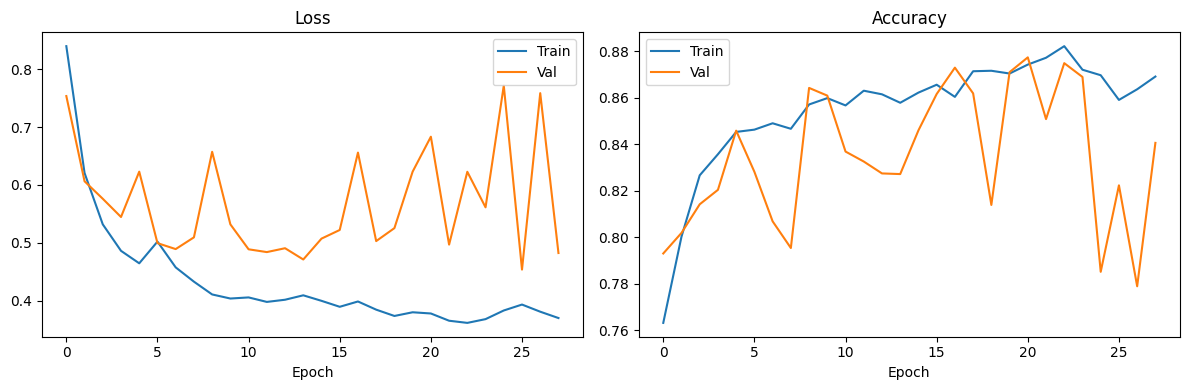


📊 그래프 저장: /home/stu/ai_project/모델집합/fusion_curves.png


In [16]:
with open(os.path.join(MODEL_DIR, "fusion_history.json"), 'w') as f:
    json.dump(history, f)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(history['train_loss'], label='Train')
ax[0].plot(history['val_loss'], label='Val')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(history['train_acc'], label='Train')
ax[1].plot(history['val_acc'], label='Val')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'fusion_curves.png'))
plt.show()

print(f"\n📊 그래프 저장: {os.path.join(MODEL_DIR, 'fusion_curves.png')}")

## 완료!

### 수정사항 (v2):
1. ✅ **Audio Scaler 사용** - `audio_scaler.pkl` 로드해서 적용
2. ✅ **AUDIO_EMPHASIS_CLASSES = [1, 2, 3]** - 클래스 1도 강조로 인식
3. ✅ 텍스트 피처를 `tensor.pt`에서 실제로 로드
4. ✅ 텍스트 강조점수(>=0.7)도 자동 라벨링에 반영

### 생성된 파일:
- `모델집합/fusion_model.pt`
- `모델집합/auto_labeled_data_with_text_v2.pt` (새 버전)
- `모델집합/fusion_history.json`
- `모델집합/fusion_curves.png`